# Softmax exercise

This exercise is analogous to the SVM exercise. You will:

- implement a fully-vectorized **loss function** for the Softmax classifier
- implement the fully-vectorized expression for its **analytic gradient**
- **check your implementation** with numerical gradient
- use a validation set to **tune the learning rate and regularization** strength
- **optimize** the loss function with **SGD**
- **visualize** the final learned weights


In [44]:
import random
import numpy as np
from utils.data_utils import load_CIFAR10
import matplotlib.pyplot as plt

%matplotlib inline
plt.rcParams['figure.figsize'] = (10.0, 8.0) # set default size of plots
plt.rcParams['image.interpolation'] = 'nearest'
plt.rcParams['image.cmap'] = 'gray'

# for auto-reloading extenrnal modules
# see http://stackoverflow.com/questions/1907993/autoreload-of-modules-in-ipython
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [45]:
import numpy as np

In [46]:
def get_CIFAR10_data(num_training=49000, num_validation=1000, num_test=1000, num_dev=500):
    """
    Load the CIFAR-10 dataset from disk and perform preprocessing to prepare
    it for the linear classifier. These are the same steps as we used for the
    SVM, but condensed to a single function.  
    """
    # Load the raw CIFAR-10 data
    cifar10_dir = 'utils/datasets/cifar-10-batches-py'
    
    # Cleaning up variables to prevent loading data multiple times (which may cause memory issue)
    try:
       del X_train, y_train
       del X_test, y_test
       print('Clear previously loaded data.')
    except:
       pass

    X_train, y_train, X_test, y_test = load_CIFAR10(cifar10_dir)
    
    # subsample the data
    mask = list(range(num_training, num_training + num_validation))
    X_val = X_train[mask]
    y_val = y_train[mask]
    mask = list(range(num_training))
    X_train = X_train[mask]
    y_train = y_train[mask]
    mask = list(range(num_test))
    X_test = X_test[mask]
    y_test = y_test[mask]
    mask = np.random.choice(num_training, num_dev, replace=False)
    X_dev = X_train[mask]
    y_dev = y_train[mask]
    
    # Preprocessing: reshape the image data into rows
    X_train = np.reshape(X_train, (X_train.shape[0], -1))
    X_val = np.reshape(X_val, (X_val.shape[0], -1))
    X_test = np.reshape(X_test, (X_test.shape[0], -1))
    X_dev = np.reshape(X_dev, (X_dev.shape[0], -1))
    
    # Normalize the data: subtract the mean image
    mean_image = np.mean(X_train, axis = 0)
    X_train -= mean_image
    X_val -= mean_image
    X_test -= mean_image
    X_dev -= mean_image
    
    # add bias dimension and transform into columns
    X_train = np.hstack([X_train, np.ones((X_train.shape[0], 1))])
    X_val = np.hstack([X_val, np.ones((X_val.shape[0], 1))])
    X_test = np.hstack([X_test, np.ones((X_test.shape[0], 1))])
    X_dev = np.hstack([X_dev, np.ones((X_dev.shape[0], 1))])
    
    return X_train, y_train, X_val, y_val, X_test, y_test, X_dev, y_dev


# Invoke the above function to get our data.
X_train, y_train, X_val, y_val, X_test, y_test, X_dev, y_dev = get_CIFAR10_data()
print('Train data shape: ', X_train.shape)
print('Train labels shape: ', y_train.shape)
print('Validation data shape: ', X_val.shape)
print('Validation labels shape: ', y_val.shape)
print('Test data shape: ', X_test.shape)
print('Test labels shape: ', y_test.shape)
print('dev data shape: ', X_dev.shape)
print('dev labels shape: ', y_dev.shape)

Train data shape:  (49000, 3073)
Train labels shape:  (49000,)
Validation data shape:  (1000, 3073)
Validation labels shape:  (1000,)
Test data shape:  (1000, 3073)
Test labels shape:  (1000,)
dev data shape:  (500, 3073)
dev labels shape:  (500,)


## Softmax Classifier

Your code for this section will all be written inside `cs231n/classifiers/softmax.py`.


In [47]:
# First implement the naive softmax loss function with nested loops.
# Open the file cs231n/classifiers/softmax.py and implement the
# softmax_loss_naive function.

from utils.classifiers.softmax import softmax_loss_naive
import time

# Generate a random softmax weight matrix and use it to compute the loss.
W = np.random.randn(3073, 10) * 0.0001
loss, grad = softmax_loss_naive(W, X_dev, y_dev, 0.0)

# As a rough sanity check, our loss should be something close to -log(0.1).
print('loss: %f' % loss)
print('sanity check: %f' % (-np.log(0.1)))

loss: 2.350216
sanity check: 2.302585


**Inline Question 1**

Why do we expect our loss to be close to -log(0.1)? Explain briefly.**

$\color{blue}{\textit Your Answer:}$ *Fill this in* 
当W初始为接近0矩阵时，loss为log(1/C)，此处C=10；


In [48]:
# Complete the implementation of softmax_loss_naive and implement a (naive)
# version of the gradient that uses nested loops.
loss, grad = softmax_loss_naive(W, X_dev, y_dev, 0.0)

# As we did for the SVM, use numeric gradient checking as a debugging tool.
# The numeric gradient should be close to the analytic gradient.
from utils.gradient_check import grad_check_sparse
f = lambda w: softmax_loss_naive(w, X_dev, y_dev, 0.0)[0]
grad_numerical = grad_check_sparse(f, W, grad, 10)

# similar to SVM case, do another gradient check with regularization
loss, grad = softmax_loss_naive(W, X_dev, y_dev, 5e1)
f = lambda w: softmax_loss_naive(w, X_dev, y_dev, 5e1)[0]
grad_numerical = grad_check_sparse(f, W, grad, 10)

numerical: -0.977170 analytic: -0.977170, relative error: 9.328836e-08
numerical: -0.615664 analytic: -0.615664, relative error: 3.771794e-08
numerical: 2.980191 analytic: 2.980191, relative error: 1.191008e-08
numerical: -5.513141 analytic: -5.513141, relative error: 5.009104e-09
numerical: 2.369463 analytic: 2.369463, relative error: 6.247483e-09
numerical: 1.763342 analytic: 1.763342, relative error: 9.390555e-09
numerical: -1.613888 analytic: -1.613888, relative error: 5.368099e-09
numerical: -1.122310 analytic: -1.122310, relative error: 8.467020e-09
numerical: 0.293121 analytic: 0.293121, relative error: 1.190667e-07
numerical: 0.868206 analytic: 0.868206, relative error: 6.649480e-09
numerical: -0.643436 analytic: -0.643436, relative error: 6.971252e-08
numerical: -0.243376 analytic: -0.243376, relative error: 7.440165e-09
numerical: -2.801843 analytic: -2.801843, relative error: 3.458383e-08
numerical: -0.389152 analytic: -0.389152, relative error: 2.580816e-07
numerical: 0.345

In [49]:
# Now that we have a naive implementation of the softmax loss function and its gradient,
# implement a vectorized version in softmax_loss_vectorized.
# The two versions should compute the same results, but the vectorized version should be
# much faster.
tic = time.time()
loss_naive, grad_naive = softmax_loss_naive(W, X_dev, y_dev, 0.000005)
toc = time.time()
print('naive loss: %e computed in %fs' % (loss_naive, toc - tic))

from utils.classifiers.softmax import softmax_loss_vectorized
tic = time.time()
loss_vectorized, grad_vectorized = softmax_loss_vectorized(W, X_dev, y_dev, 0.000005)
toc = time.time()
print('vectorized loss: %e computed in %fs' % (loss_vectorized, toc - tic))

# As we did for the SVM, we use the Frobenius norm to compare the two versions
# of the gradient.
grad_difference = np.linalg.norm(grad_naive - grad_vectorized, ord='fro')
print('Loss difference: %f' % np.abs(loss_naive - loss_vectorized))
print('Gradient difference: %f' % grad_difference)

naive loss: 2.350216e+00 computed in 0.486898s
vectorized loss: 2.350216e+00 computed in 0.015621s
Loss difference: 0.000000
Gradient difference: 0.000000


In [54]:
# Use the validation set to tune hyperparameters (regularization strength and
# learning rate). You should experiment with different ranges for the learning
# rates and regularization strengths; if you are careful you should be able to
# get a classification accuracy of over 0.35 on the validation set.
from utils.classifiers.linear_classifier import Softmax
results = {}
best_val = -1
best_softmax = None
learning_rates = np.linspace(8e-8, 2e-7,10)
regularization_strengths = np.linspace(1e4, 5e4,3)

################################################################################
# TODO:                                                                        #
# Use the validation set to set the learning rate and regularization strength. #
# This should be identical to the validation that you did for the SVM; save    #
# the best trained softmax classifer in best_softmax.                          #
################################################################################
# *****START OF YOUR CODE (DO NOT DELETE/MODIFY THIS LINE)*****

for lr in learning_rates:
    for reg in regularization_strengths:
        clf=Softmax()
        loss_hist = clf.train(X_train, y_train, learning_rate=lr, reg=reg,
                          num_iters=1500, verbose=True)
        y_train_pred = clf.predict(X_train)
        y_val_pred = clf.predict(X_val)
        train_acc=np.mean(y_train == y_train_pred)
        val_acc=np.mean(y_val == y_val_pred)
        results[(lr,reg)]=train_acc,val_acc
        if(val_acc>best_val):
            best_softmax=clf
            best_val=val_acc
# *****END OF YOUR CODE (DO NOT DELETE/MODIFY THIS LINE)*****
    
# Print out results.
for lr, reg in sorted(results):
    train_accuracy, val_accuracy = results[(lr, reg)]
    print('lr %e reg %e train accuracy: %f val accuracy: %f' % (
                lr, reg, train_accuracy, val_accuracy))
    
print('best validation accuracy achieved during cross-validation: %f' % best_val)

iteration 0 / 1500: loss 315.686096
iteration 100 / 1500: loss 227.493717
iteration 200 / 1500: loss 165.418535
iteration 300 / 1500: loss 120.244175
iteration 400 / 1500: loss 87.788473
iteration 500 / 1500: loss 64.004958
iteration 600 / 1500: loss 46.929201
iteration 700 / 1500: loss 34.585061
iteration 800 / 1500: loss 25.663133
iteration 900 / 1500: loss 19.158448
iteration 1000 / 1500: loss 14.334536
iteration 1100 / 1500: loss 10.982483
iteration 1200 / 1500: loss 8.484199
iteration 1300 / 1500: loss 6.713143
iteration 1400 / 1500: loss 5.518136
iteration 0 / 1500: loss 947.950872
iteration 100 / 1500: loss 362.202630
iteration 200 / 1500: loss 139.335878
iteration 300 / 1500: loss 54.436242
iteration 400 / 1500: loss 22.081020
iteration 500 / 1500: loss 9.688407
iteration 600 / 1500: loss 5.003857
iteration 700 / 1500: loss 3.210740
iteration 800 / 1500: loss 2.595738
iteration 900 / 1500: loss 2.227403
iteration 1000 / 1500: loss 2.168457
iteration 1100 / 1500: loss 2.120859
i

iteration 1300 / 1500: loss 2.125192
iteration 1400 / 1500: loss 2.095197
iteration 0 / 1500: loss 308.721868
iteration 100 / 1500: loss 170.738923
iteration 200 / 1500: loss 95.372356
iteration 300 / 1500: loss 53.842163
iteration 400 / 1500: loss 30.565402
iteration 500 / 1500: loss 17.839493
iteration 600 / 1500: loss 10.810174
iteration 700 / 1500: loss 6.979403
iteration 800 / 1500: loss 4.712500
iteration 900 / 1500: loss 3.527296
iteration 1000 / 1500: loss 2.821237
iteration 1100 / 1500: loss 2.457599
iteration 1200 / 1500: loss 2.310687
iteration 1300 / 1500: loss 2.046276
iteration 1400 / 1500: loss 2.018654
iteration 0 / 1500: loss 920.367338
iteration 100 / 1500: loss 158.081163
iteration 200 / 1500: loss 28.614321
iteration 300 / 1500: loss 6.610265
iteration 400 / 1500: loss 2.837552
iteration 500 / 1500: loss 2.207807
iteration 600 / 1500: loss 2.120516
iteration 700 / 1500: loss 2.093813
iteration 800 / 1500: loss 2.129080
iteration 900 / 1500: loss 2.174965
iteration 1

iteration 1300 / 1500: loss 2.109375
iteration 1400 / 1500: loss 2.106191
lr 8.000000e-08 reg 1.000000e+04 train accuracy: 0.344796 val accuracy: 0.367000
lr 8.000000e-08 reg 3.000000e+04 train accuracy: 0.324224 val accuracy: 0.331000
lr 8.000000e-08 reg 5.000000e+04 train accuracy: 0.308367 val accuracy: 0.322000
lr 9.333333e-08 reg 1.000000e+04 train accuracy: 0.348939 val accuracy: 0.367000
lr 9.333333e-08 reg 3.000000e+04 train accuracy: 0.322694 val accuracy: 0.331000
lr 9.333333e-08 reg 5.000000e+04 train accuracy: 0.307061 val accuracy: 0.327000
lr 1.066667e-07 reg 1.000000e+04 train accuracy: 0.357490 val accuracy: 0.363000
lr 1.066667e-07 reg 3.000000e+04 train accuracy: 0.321184 val accuracy: 0.333000
lr 1.066667e-07 reg 5.000000e+04 train accuracy: 0.309449 val accuracy: 0.323000
lr 1.200000e-07 reg 1.000000e+04 train accuracy: 0.354776 val accuracy: 0.377000
lr 1.200000e-07 reg 3.000000e+04 train accuracy: 0.327531 val accuracy: 0.330000
lr 1.200000e-07 reg 5.000000e+04 tr

In [55]:
# evaluate on test set
# Evaluate the best softmax on test set
y_test_pred = best_softmax.predict(X_test)
test_accuracy = np.mean(y_test == y_test_pred)
print('softmax on raw pixels final test set accuracy: %f' % (test_accuracy, ))

softmax on raw pixels final test set accuracy: 0.367000


**Inline Question 2** - *True or False*

Suppose the overall training loss is defined as the sum of the per-datapoint loss over all training examples. It is possible to add a new datapoint to a training set that would leave the SVM loss unchanged, but this is not the case with the Softmax classifier loss.

$\color{blue}{\textit Your Answer:}$
T

$\color{blue}{\textit Your Explanation:}$
在softmax中，每个数据点都在计算总损失时发挥作用，而SMV中，损失结果取决于相对得分，若新增数据点的得分比正确分数少1则总损失不变


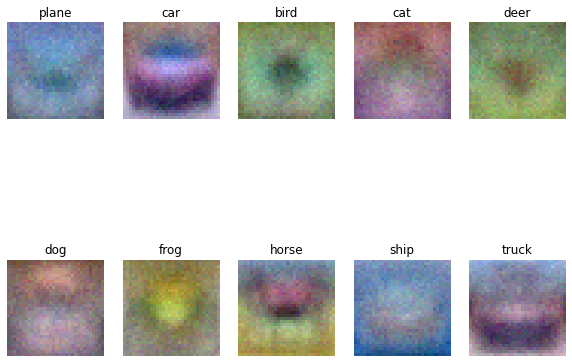

In [56]:
# Visualize the learned weights for each class
w = best_softmax.W[:-1,:] # strip out the bias
w = w.reshape(32, 32, 3, 10)

w_min, w_max = np.min(w), np.max(w)

classes = ['plane', 'car', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']
for i in range(10):
    plt.subplot(2, 5, i + 1)
    
    # Rescale the weights to be between 0 and 255
    wimg = 255.0 * (w[:, :, :, i].squeeze() - w_min) / (w_max - w_min)
    plt.imshow(wimg.astype('uint8'))
    plt.axis('off')
    plt.title(classes[i])